In [1]:
# Imports

from datetime import datetime, timedelta

from Database import db

import numpy as np
import pickle
import os

import matplotlib.pyplot as plt

from keras.optimizers import RMSprop
from keras.models import Sequential, load_model, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, concatenate, SpatialDropout1D, GRU
from keras.layers import Dense, Flatten, Embedding, LSTM, Activation, BatchNormalization, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [2]:
# Options

stocks      = ['AAPL', 'AMD', 'AMZN', 'GOOG', 'MSFT']
all_sources = ['reddit', 'reuters', 'twitter', 'seekingalpha']

max_length  = 50
vocab_size  = None # Set by tokenizer
emb_size    = 300

epochs     = 180
batch_size = 32

In [3]:

def make_headline_to_effect_data():
    """
    Headline -> Effect
    
    Creates essentially the X, Y data for the embedding model to use
    when analyzing/encoding headlines. Returns a list of headlines and
    a list of corresponding 'effects' which represent a change in the stock price.
    """
    meta, headlines, effects = [], [], []
    
    with db() as (conn, cur):
        
        for stock in stocks:
            
            print("Fetching Stock..." + stock)
            
            ## Go through all the headlines ##
            
            cur.execute("SELECT date, source, content FROM headlines WHERE stock=? AND LENGTH(content) >= 16", [stock])
            headline_query = cur.fetchall()
            
            for (date, source, content) in headline_query:
                
                event_date = datetime.strptime(date, '%Y-%m-%d') # The date of headline
                
                add_time = lambda e, days: (e + timedelta(days=days)).strftime('%Y-%m-%d')
                
                ## Find corresponding tick data ## 
                
                cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                            [stock, 
                             add_time(event_date, -3), 
                             add_time(event_date, 0)])
                
                before_headline_ticks = cur.fetchall()
                
                cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                            [stock, 
                             add_time(event_date, 1), 
                             add_time(event_date, 4)])
                
                after_headline_ticks = cur.fetchall()
                
                ## Create training example ##
                
                if len(before_headline_ticks) > 0 and len(after_headline_ticks) > 0:
                    
                    previous_tick = before_headline_ticks[-1][0]
                    result_tick = after_headline_ticks[0][0]
                
                    if result_tick > previous_tick:
                        
                        effect = [1., 0.]
                        
                    else:
                        
                        effect = [0., 1.]
                        
                    meta.append((source, event_date.weekday()))
                    headlines.append(content)
                    effects.append(effect)
                    
    return meta, headlines, np.array(effects)


In [4]:

def encode_sentences(meta, sentences, tokenizer=None, max_length=100, vocab_size=100):
    """
    Encoder
    
    Takes a list of headlines and converts them into vectors
    """
    ## Encoding Sentences
    
    if not tokenizer:
        
        tokenizer = Tokenizer(num_words=vocab_size, filters='', lower=False) # Already Preprocessed
    
        tokenizer.fit_on_texts(sentences)
    
    encoded_headlines = tokenizer.texts_to_sequences(sentences)
    
    padded_headlines = pad_sequences(encoded_headlines, maxlen=max_length, padding='post')
    
    ## Encoding Meta Data
    
    # OneHot(Source) + OneHot(WeekDay)
    
    meta_matrix = np.zeros((len(sentences), len(all_sources) + 7))
    index = 0
    
    for (source, weekday) in meta:
        
        meta_matrix[index, all_sources.index(source)] = 1
        meta_matrix[index, len(all_sources) + weekday] = 1
        
        index += 1
    
    return meta_matrix, padded_headlines, tokenizer


In [5]:

def split_data(X, X2, Y, ratio):
    """
    Splits X/Y to Train/Test
    """
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    
    X  = X[indexes]
    X2 = X2[indexes]
    Y  = Y[indexes]
    
    train_size = int(len(X) * ratio)
    
    trainX,  testX  = X[:train_size],  X[train_size:]
    trainX2, testX2 = X2[:train_size], X2[train_size:]
    trainY,  testY  = Y[:train_size],  Y[train_size:]
    
    return trainX, trainX2, trainY, testX, testX2, testY


In [8]:

def get_embedding_matrix(tokenizer, pretrained_file='glove.840B.300d.txt', purge=False):
    """Load Vectors from Glove File"""
    print("Loading...WordVecs")
    
    ## Load Glove File (Super Slow) ##
    
    glove_db = dict()
    
    with open(os.path.join('..', 'data', pretrained_file), 'r', encoding="utf-8") as glove:

        for line in glove:

            values = line.split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove_db[word] = coefs

    print('Loaded Word Vectors...' + str(len(glove_db)))
    
    ## Set Embeddings ##
    
    embedding_matrix = np.zeros((vocab_size + 1, emb_size))
    
    for word, i in tokenizer.word_index.items():
        
        embedding_vector = glove_db.get(word)
        
        if embedding_vector is not None:
            
            embedding_matrix[i] = embedding_vector
            
        elif purge:
            
            with db() as (conn, cur):
                
                cur.execute("SELECT 1 FROM specialwords WHERE word=?", [word])
                
                if len(cur.fetchall()) == 0:
                    
                    print("Purge..." + word)

                    cur.execute("DELETE FROM headlines WHERE content LIKE ?", ["%" + word + "%"])
                    conn.commit()
            
    return embedding_matrix, glove_db

def get_model(emb_matrix):
    
    ## Headline ##
    
    headline_input = Input(shape=(max_length,))
    
    emb = Embedding(vocab_size + 1, emb_size, input_length=max_length, weights=[emb_matrix], trainable=True)(headline_input)
    emb = SpatialDropout1D(.1)(emb)
    
    # conv = Conv1D(filters=64, kernel_size=5, padding='same', activation='selu')(emb)
    # conv = MaxPooling1D(pool_size=3)(conv)
    
    text_rnn = LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(emb)
    text_rnn = Activation('relu')(text_rnn)
    text_rnn = BatchNormalization()(text_rnn)
    
    text_rnn = LSTM(300, dropout=0.3, recurrent_dropout=0.3)(text_rnn)
    text_rnn = Activation('relu')(text_rnn)
    text_rnn = BatchNormalization()(text_rnn)
    
    ## Source ##
    
    meta_input = Input(shape=(len(all_sources) + 7,))
    
    ## Combined ##
    
    merged = concatenate([text_rnn, meta_input])
    
    dense_1 = Dense(300)(merged)
    dense_1 = Activation('relu')(dense_1)
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Dropout(0.5)(dense_1)
    
    # dense_2 = Dense(300)(dense_1)
    # dense_2 = Activation('relu')(dense_2)
    # dense_2 = BatchNormalization()(dense_2)
    # dense_2 = Dropout(0.5)(dense_2)
    
    dense_3 = Dense(200)(dense_1)
    dense_3 = Activation('relu')(dense_3)
    dense_3 = BatchNormalization()(dense_3)
    dense_3 = Dropout(0.5)(dense_3)
    
    dense_4 = Dense(2)(dense_3)
    out = Activation('softmax')(dense_4)
    
    model = Model(inputs=[headline_input, meta_input], outputs=out)
    
    optimizer = RMSprop(lr=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    
    return model


Fetching Stock...AAPL
Fetching Stock...AMD
Fetching Stock...AMZN
Fetching Stock...GOOG
Fetching Stock...MSFT
Found Words...10586
Loading...WordVecs
Loaded Word Vectors...2196016
Purge...realdont
Purge...gtav
Purge...trebleized
Purge...gthis
Purge...rad**PRODUCT**hack
Purge...arkit
Purge...sisfoft
Purge...happeninggif
Purge...tydlig
Purge...airpods
Purge...chadder
Purge...testut
Purge...masterracers
Purge...luckynb
Purge...stockafter
Purge...nonblurry
Purge...yuphoria
Purge...lifewhat
Purge...ruddocks
Purge...smsmms
Purge...cheapbudget
Purge...datafree
Purge...studentyr
Purge...zegarra
Purge...sivori
Purge...midoctober
Purge...nadella
Purge...keyboardtrackpad
Purge...tvcom
Purge...**PRODUCT**instinct
Purge...apkupdater
Purge...axpowered
Purge...alibabas
Purge...prorender
Purge...mediastore
Purge...sonymicrosoftnintendo
Purge...miniitx
Purge...vivebrand
Purge...instacart
Purge...mustknow
Purge...instantwatcher
Purge...ydbbaebox
Purge...typec
Purge...protalinski
Purge...neweggca
Purge...a

Purge...**COMPANY**r
Purge...minutebyminute
Purge...fdicinsured
Purge...apupowered
Purge...fccs
Purge...freesync
Purge...appchat
Purge...smile**COMPANY**com
Purge...bware
Purge...boerse
Purge...**PRODUCT**enabled
Purge...microcenters
Purge...chipandpin
Purge...antiencryption
Purge...chartsmindblank
Purge...apkmirrors
Purge...communityrun
Purge...prter
Purge...smisek
Purge...updateie
Purge...alibabalinked
Purge...stockmindfactory
Purge...gncs
Purge...qhd
Purge...dmark
Purge...gamernexus
Purge...workswith
Purge...ilost
Purge...rnexusp
Purge...fiveyearold
Purge...rad**PRODUCT**
Purge...mindfactoryde
Purge...trilliondollar
Purge...farenjoy
Purge...gunmans
Purge...googletranslate
Purge...parsey
Purge...russianlinked
Purge...dashclock
Purge...finewine
Purge...**PRODUCT**mac
Purge...eufy
Purge...independentunknown
Purge...bottomfiring
Purge...neverbeforeseen
Purge...ownersis
Purge...thurrottcom
Purge...presplit
Purge...ryzen
Purge...familyfriends
Purge...**COMPANY**play
Purge...nocontract
Pur

Purge...industryfirst
Purge...exiphone
Purge...toptier
Purge...gigback
Purge...evleaks
Purge...stload
Purge...flagshipwill
Purge...bestworst
Purge...alphacool
Purge...ausdroid
Purge...arment
Purge...**PRODUCT**like
Purge...recognizition
Purge...hypetrain
Purge...muslimban
Purge...anydo
Purge...ndgeneration
Purge...blumoo
Purge...lessknow
Purge...hardwareschottede
Purge...mitx
Purge...nokiapoweruser
Purge...lenovomotorola
Purge...wileyfox
Purge...tifu
Purge...**COMPANY**like
Purge...mintcom
Purge...moviesshows
Purge...imininent
Purge...krzanich
Purge...computerbasede
Purge...isseems
Purge...r**PRODUCT**
Purge...artemr
Purge...panoramafunction
Purge...heat**PRODUCT**
Purge...fordwaymo
Purge...autovoice
Purge...rossmanns
Purge...bezelfree
Purge...directcanadacom
Purge...pcper
Purge...hackedsaid
Purge...subscriptionbased
Purge...**PRODUCT**pay
Purge...cityman
Purge...httpoem**PRODUCT**phonecom
Purge...topolsky
Purge...smominru
Purge...**PRODUCT**xl
Purge...trudeaus
Purge...teknikos
Purge..

In [7]:

if __name__ == "__main__":
    
    meta, headlines, effects = make_headline_to_effect_data()
    
    encoded_meta, encoded_headlines, toke = encode_sentences(meta, 
                                                             headlines, 
                                                             max_length=max_length, 
                                                             vocab_size=vocab_size)
    
    vocab_size = len(toke.word_counts)
    print("Found Words..." + str(vocab_size))
    
    emb_matrix, glove_db = get_embedding_matrix(toke)
    
    trainX, trainX2, trainY, testX, testX2, testY = split_data(encoded_headlines, encoded_meta, effects, .85)
    
    print(trainX.shape, trainX2.shape, testY.shape)


Fetching Stock...AAPL
Fetching Stock...AMD
Fetching Stock...AMZN
Fetching Stock...GOOG
Fetching Stock...MSFT
Found Words...8561
Loading...WordVecs
Loaded Word Vectors...2196016
(6357, 50) (6357, 11) (1122, 2)


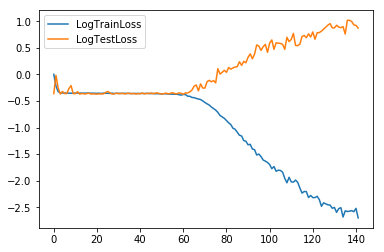

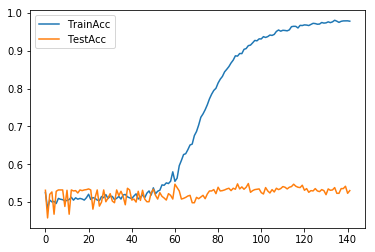

In [10]:
# TRAIN MODEL

if __name__ == "__main__":
    
    ## Save Tokenizer ##
    
    with open(os.path.join('..', 'models', 'toke.pkl'), 'wb') as toke_file:
        pickle.dump(toke, toke_file, protocol=pickle.HIGHEST_PROTOCOL)
        
    ## Create Model ##
    
    model = get_model(emb_matrix)
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(datetime.now().strftime("%Y,%m,%d-%H,%M,%S")))
    e_stopping = EarlyStopping(monitor='val_loss', patience=80)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'media-headlines.h5'), 
                                 monitor='val_acc',
                                 verbose=0,
                                 save_best_only=True)
    
    ## Train ##
    
    history = model.fit([trainX, trainX2],
                        trainY,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=([testX, testX2], testY),
                        verbose=0,
                        callbacks=[e_stopping, checkpoint, tensorboard])
    
    ## Display Train History ##
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
    

In [ ]:
# TEST MODEL

if __name__ == "__main__":
    
    ## Load Model For Manual Testing ##
    
    with open(os.path.join('..', 'models', 'toke.pkl'), 'rb') as toke_file:
        toke = pickle.load(toke_file)
    
    model = load_model(os.path.join('..', 'models', 'media-headlines.h5'))
    
    ## Fake Unique Test Data ##
    
    test_sents = [
        'the ceo of **COMPANY** was fired after selling a bad **PRODUCT**', 
        '**COMPANY** just released a **PRODUCT** thats better than every other company',
        '**COMPANY**s **PRODUCT** killed a family of ducks in a sensor malfunction',
        'the **COMPANY** team released a breakthrough in **PRODUCT** gaming'
    ]
    
    ## Process ##
    
    encoded_meta, test_encoded, _ = encode_sentences([['reuters', 0], ['twitter', 1], ['reddit', 2], ['seekingalpha', 3]], 
                                                      test_sents, 
                                                      tokenizer=toke, 
                                                      max_length=max_length, 
                                                      vocab_size=vocab_size)
    
    predictions = model.predict([test_encoded, encoded_meta])
    
    ## Display Predictions ##
    
    for i in range(len(test_sents)):
        
        print("")
        print(test_sents[i])
        print(predictions[i])
        print("Stock Will Go Up" if np.argmax(predictions[i]) == 0 else "Stock Will Go Down")


In [12]:
# TEST MODEL

if __name__ == "__main__":
    
    ## Load Model For Manual Testing ##
    
    with open(os.path.join('..', 'models', 'toke.pkl'), 'rb') as toke_file:
        toke = pickle.load(toke_file)
    
    model = load_model(os.path.join('..', 'models', 'media-headlines.h5'))
    
    ## **This Test May Overlap w/Train Data** ##
    
    current_date = '2018-02-05'
    predict_date = '2018-02-06'
    stock = 'AAPL'
    
    with db() as (conn, cur):
        
        ## Select Actual Stock Values ##
        
        cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                    [stock, current_date, predict_date])
        ticks = cur.fetchall()
        
        ## Find Headlines ##
    
        cur.execute("SELECT date, source, content FROM headlines WHERE date=? AND stock=?", [current_date, stock])
        headlines = cur.fetchall()
        
        ## Process ##
        
        meta, test_sents = [], []
        
        for (date, source, content) in headlines:
            
            meta.append([source, datetime.strptime(date, '%Y-%m-%d').weekday()])
            test_sents.append(content)
            
        encoded_meta, test_encoded, _ = encode_sentences(meta, 
                                                         test_sents, 
                                                         tokenizer=toke, 
                                                         max_length=max_length,
                                                         vocab_size=vocab_size)
        
        predictions = model.predict([test_encoded, encoded_meta])
        
        ## Display ##
        
        print("Using: " + str(test_sents))
        
        print("Predicting Change Coef: " +  str( round(np.mean(predictions[:, 0]) - .5, 2) * 2 ))
        
        print("Actual Stock Change: " + str( round(ticks[-1][0] - ticks[0][0], 2) ))
            

Using: ['**PRODUCT** remains worlds most popular tablet as **COMPANY** outsells samsung and amazon combined last year', 'telegram was pulled because of child pornography says **COMPANY**s phil schiller', 'does anyone else wish for an updated **PRODUCT** mini', 'only a few bump stocks turned in to police despite massachusetts ban', '**COMPANY** inc is building a massive data center in southwest chinas guizhou province which is expected to open in', '**COMPANY** has increased prices of all its **PRODUCT** models by approx except for **PRODUCT** se which is assembled in', '**COMPANY** supplier cirrus plunges after disappointing results', 'broadcom unveils bln best and final offer for qualcomm', 'qualcomm shares fall as reports say **COMPANY** may scrap its chips', 'damp **PRODUCT** demand to pressure rf chipmakers morgan stanley says']
Predicting Change Coef: 0.04
Actual Stock Change: 6.54
